# Assignment 1: ICU Mortality Prediction

Authors:  
Sviatlana Matsiuk

## Imports

In [63]:
import pandas as pd
import numpy as np

## Load data


In [64]:
training_data = pd.read_csv('data/training_v2.csv')
data_dictionary = pd.read_csv('data/WiDS_Datathon_2020_Dictionary.csv')

Training data:

In [65]:
training_data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


Dictionary:

In [66]:
data_dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,NaN,integer,Unique identifier associated with a patient un...,NaN
1,identifier,hospital_id,NaN,integer,Unique identifier associated with a hospital,NaN
2,identifier,patient_id,NaN,integer,Unique identifier associated with a patient,NaN
3,demographic,hospital_death,NaN,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,NaN


## Step 1: Cleaning data

In [67]:
# Check for missing values
missing_values = training_data.isnull().sum()
missing_values[missing_values > 0]

age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 175, dtype: int64

In [68]:
# Drop patient_id because it’s just a unique identifier and likely not useful for predictive modeling
training_data = training_data.drop('patient_id', axis=1)

# Dropping columns with more than 50% missing values
threshold = len(training_data) * 0.5
training_data = training_data.dropna(thresh=threshold, axis=1)

# Dropping specific rows where hospital_death is missing
training_data = training_data.dropna(subset=['hospital_death'])

training_data.reset_index(drop=True, inplace=True)

In [69]:
training_data.head()

original_data = training_data

## Step 2: Imputation for Missing Values and Encoding Categorical Data

In [70]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Impute missing values using the median for numerical columns
imputer = SimpleImputer(strategy='median')
numeric_columns = training_data.select_dtypes(include=['number']).columns
training_data[numeric_columns] = imputer.fit_transform(training_data[numeric_columns])

# Encoding categorical columns using Label Encoding
label_encoder = LabelEncoder()
categorical_columns = training_data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    training_data[column] = label_encoder.fit_transform(training_data[column].astype(str))

## Step 3: Handling Class Imbalance

In [71]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to handle class imbalance
smote = SMOTE()
X = training_data.drop('hospital_death', axis=1)
y = training_data['hospital_death']
X_resampled, y_resampled = smote.fit_resample(X, y)

## Step 3: Modeling 

### Model 1: Random Forest Classifier

Why Random Forest?
- Robustness: Random Forest is known for its robustness and good performance on many problems, including classification tasks like predicting ICU mortality. It handles both linear and non-linear relationships well.
- Handling Imbalanced Data: It naturally handles unbalanced data by constructing multiple decision trees and using averaging to improve accuracy and control over-fitting.
- Feature Importance: Provides straightforward metrics to evaluate the importance of each feature, which can be crucial for understanding the factors influencing ICU mortality predictions.


In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [73]:
import seaborn as sns
def plot_feature_importances(model, features, figsize=(10, 30)):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort features by importance

    plt.figure(figsize=figsize)
    sns.barplot(y=features[indices], x=importances[indices])
    
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

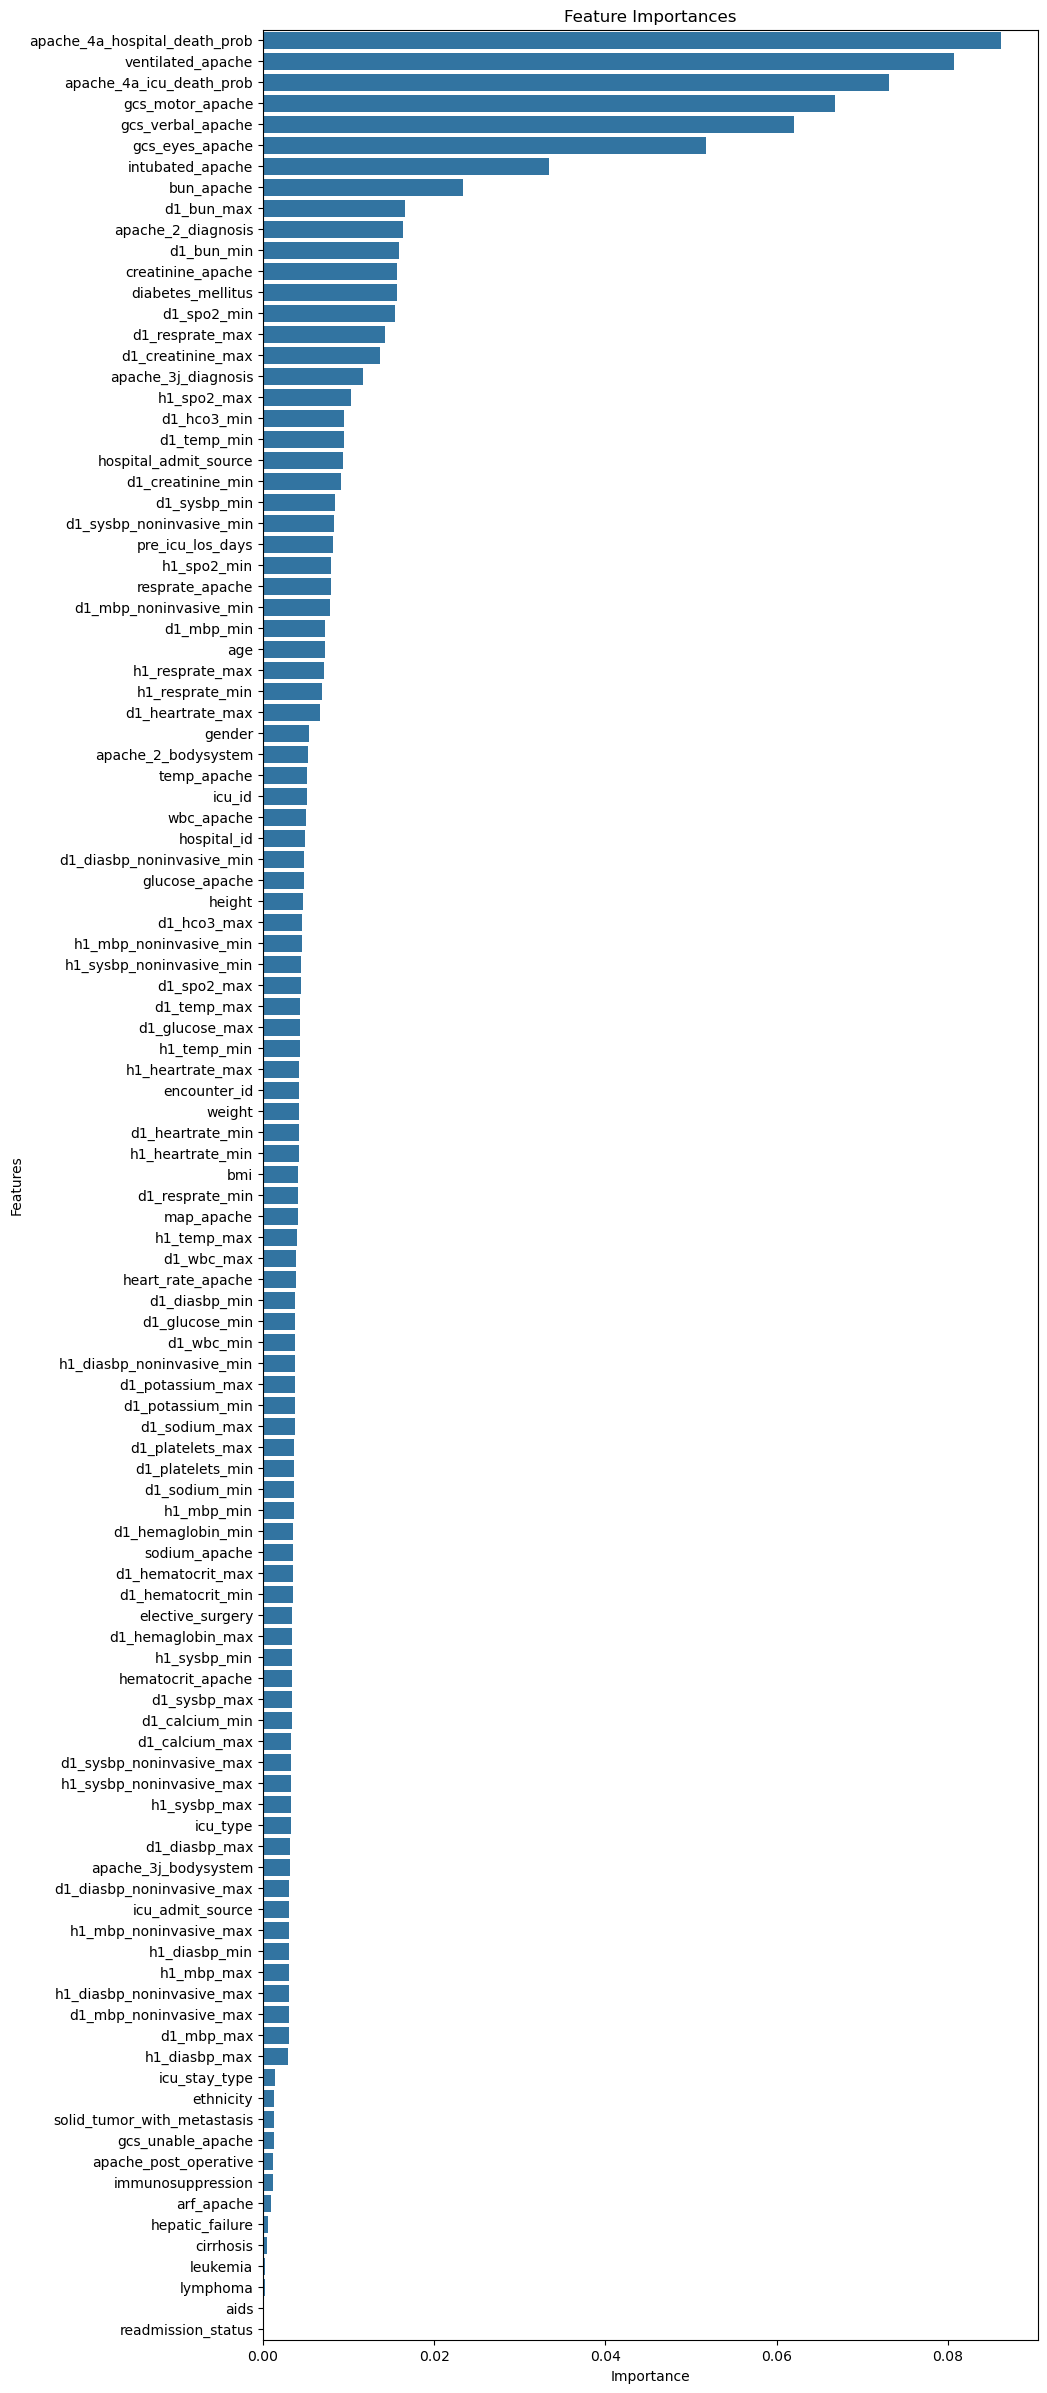

In [74]:
plot_feature_importances(rf_model, X_train.columns)

### Model 2: Logistic Regression

Why Logistic Regression?

- Interpretability: Logistic Regression is highly interpretable, which is valuable in medical applications where understanding the influence of variables is crucial.
- Baseline Model: It serves well as a baseline model for binary classification problems. Its performance on the dataset can provide a benchmark to evaluate more complex models.
- Speed: It is computationally less expensive than many other algorithms, making it a good choice for initial explorations of the data.

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Logistic Regression model
pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(max_iter=10000, solver='saga', C=0.1)
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=10000, solver='saga'))])

In [76]:
def plot_logistic_regression_coefficients(model, features, figsize=(10, 30)):
    if hasattr(model, 'steps'):
        lr_model = model.named_steps['logisticregression']
    else:
        lr_model = model

    coefficients = lr_model.coef_[0]
    indices = np.argsort(coefficients)[::-1] 

    # Create the plot
    plt.figure(figsize=figsize)
    sns.barplot(y=np.array(features)[indices], x=coefficients[indices], orient='h')
    
    plt.title('Logistic Regression Coefficients')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.show()

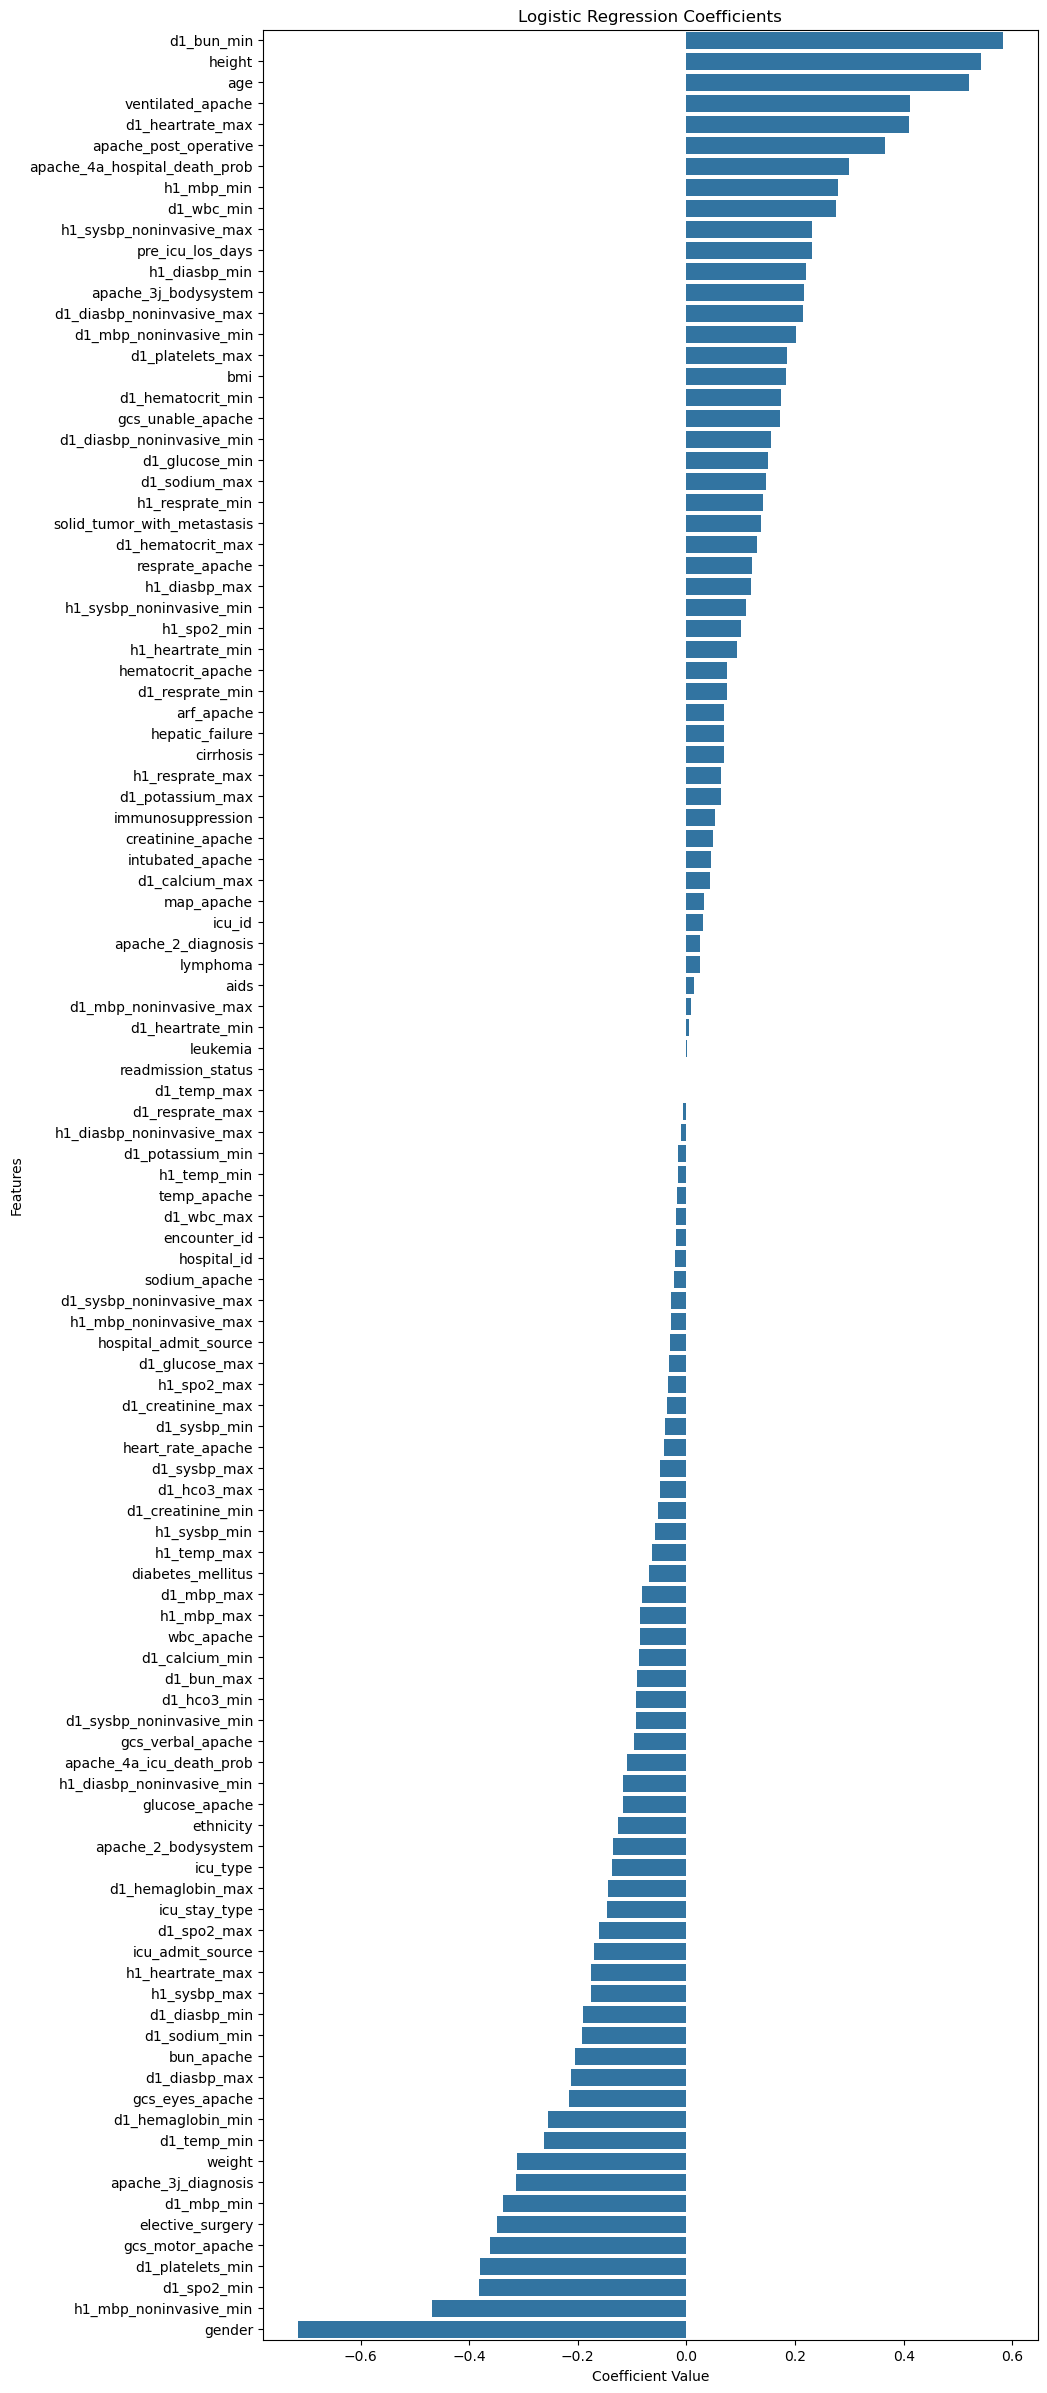

In [77]:
plot_logistic_regression_coefficients(pipeline, X_train.columns)

## Step 4: Models Evaluation

In [78]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

In [81]:
# Evaluate Rainbow Forest 
evaluate_model(rf_model, X_test, y_test)

Accuracy: 0.9547
ROC-AUC: 0.9910
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     25067
         1.0       0.96      0.95      0.95     25212

    accuracy                           0.95     50279
   macro avg       0.95      0.95      0.95     50279
weighted avg       0.95      0.95      0.95     50279

Confusion Matrix:
[[24057  1010]
 [ 1269 23943]]


In [83]:
# Evaluate Logistic Regression
evaluate_model(pipeline, X_test, y_test)

Accuracy: 0.8277
ROC-AUC: 0.9050
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     25067
         1.0       0.83      0.83      0.83     25212

    accuracy                           0.83     50279
   macro avg       0.83      0.83      0.83     50279
weighted avg       0.83      0.83      0.83     50279

Confusion Matrix:
[[20796  4271]
 [ 4391 20821]]


Based on your evaluations, it's clear that the Random Forest Classifier significantly outperforms the Logistic Regression model across all key metrics: accuracy, ROC-AUC, precision, recall, and F1-score. This difference can be attributed to the inherent strengths of Random Forest in handling complex, non-linear relationships and its robustness to overfitting thanks to the ensemble approach.

### Evaluate Models Without Imputation

In [84]:
data_no_impute = original_data.dropna(axis=1)

# Split the data
X_no_impute = data_no_impute.drop('hospital_death', axis=1)
y_no_impute = data_no_impute['hospital_death']
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no_impute, y_no_impute, test_size=0.3, random_state=42)

In [85]:
# Retrain Rainbow Forest Without Imputation
rf_model.fit(X_train_no, y_train_no)

RandomForestClassifier(random_state=42)

In [87]:
# Evaluate Rainbow Forest Without Imputation
evaluate_model(rf_model, X_test_no, y_test_no)

Accuracy: 0.9269
ROC-AUC: 0.8777
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     25150
         1.0       0.70      0.26      0.38      2364

    accuracy                           0.93     27514
   macro avg       0.82      0.63      0.67     27514
weighted avg       0.91      0.93      0.91     27514

Confusion Matrix:
[[24881   269]
 [ 1741   623]]


In [89]:
# Retrain Logistic Regression Without Imputation
pipeline.fit(X_train_no, y_train_no)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=10000, solver='saga'))])

In [91]:
# Evaluate Logistic Regression Without Imputation
evaluate_model(pipeline, X_test_no, y_test_no)

Accuracy: 0.9220
ROC-AUC: 0.8719
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     25150
         1.0       0.62      0.24      0.35      2364

    accuracy                           0.92     27514
   macro avg       0.77      0.62      0.65     27514
weighted avg       0.91      0.92      0.91     27514

Confusion Matrix:
[[24789   361]
 [ 1785   579]]


 #### Evaluate Model Without Handling Class Imbalance

In [93]:
X_train_ub, X_test_ub, y_train_ub, y_test_ub = train_test_split(X, y, test_size=0.3, random_state=42)

In [96]:
# Retrain and evaluate the Rainbow Forest model without handling class imbalance
rf_model.fit(X_train_ub, y_train_ub)
evaluate_model(rf_model, X_test_ub, y_test_ub)

Accuracy: 0.9269
ROC-AUC: 0.8777
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     25150
         1.0       0.70      0.26      0.38      2364

    accuracy                           0.93     27514
   macro avg       0.82      0.63      0.67     27514
weighted avg       0.91      0.93      0.91     27514

Confusion Matrix:
[[24881   269]
 [ 1741   623]]


In [97]:
# Retrain and evaluate the Logistic Regression model without handling class imbalance
pipeline.fit(X_train_ub, y_train_ub)
evaluate_model(pipeline, X_test_ub, y_test_ub)

Accuracy: 0.9220
ROC-AUC: 0.8719
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     25150
         1.0       0.62      0.24      0.35      2364

    accuracy                           0.92     27514
   macro avg       0.77      0.62      0.65     27514
weighted avg       0.91      0.92      0.91     27514

Confusion Matrix:
[[24789   361]
 [ 1785   579]]


## Step 5: Analysis Data. Possibility to estimate trends of risk

- Time-Related Data Available
Based on the data dictionary, there are several variables that provide temporal information about the patient's stay in the ICU, particularly in terms of physiological measurements taken during the first 24 hours and the first hour of the ICU stay. This includes:

- d1_ and h1_ Prefix Variables: These variables indicate data collected during the first day (d1_) and first hour (h1_) of the ICU stay. Variables like d1_heartrate_max and h1_heartrate_max capture the maximum heart rate recorded during these periods, respectively.
Pre-ICU Length of Stay (pre_icu_los_days): Indicates the duration in days that the patient was in the hospital before being admitted to the ICU. This could be used to assess the patient's condition prior to ICU admission.
- Motivation for Using Time-Series Data
The presence of these time-stamped data points, particularly the first day and hour measurements, is crucial for several reasons:

- Risk Assessment Over Time: By examining how vital signs change over the first 24 hours (a critical window for many ICU admissions), clinicians can better understand the trajectory of a patient's health. This can help in early identification of deterioration, allowing for timely intervention.
- Windowing Techniques: With measurements segmented into the first hour and first day, you can apply windowing techniques to analyze trends over these intervals. For instance, calculating the rate of change in vital signs or comparing early measurements with later ones could provide insights into patient stability or recovery.
- Predictive Modeling: Incorporating temporal dynamics into predictive models can improve their accuracy and sensitivity in detecting mortality risk. For example, models can be adjusted based on the criticality shown in the initial hours of care.

The availability of detailed time-stamped measurements during critical periods (first hour and day) in the ICU allows for effective application of windowing techniques to assess risk trends. These methods can significantly contribute to understanding patient risk dynamics and enhancing predictive models' performance, ultimately aiding in more informed clinical decision-making. This motivates the use of such time-series data to potentially improve outcomes through better risk management and treatment adjustments.

## Results and Discussion

### Rainbow Forest Model

- With Imputation
Accuracy: 0.9547
Precision: 0.96 (Class 1), 0.95 (Class 0)
Recall: 0.95 (Class 1), 0.96 (Class 0)
F1-Score: 0.95 (Class 1), 0.95 (Class 0)
ROC-AUC: 0.9910
Confusion Matrix: True Negative = 24057, False Positive = 1010, False Negative = 1269, True Positive = 23943

- Without Imputation
Accuracy: 0.9269
Precision: 0.70 (Class 1), 0.93 (Class 0)
Recall: 0.26 (Class 1), 0.99 (Class 0)
F1-Score: 0.38 (Class 1), 0.96 (Class 0)
ROC-AUC: 0.8777
Confusion Matrix: True Negative = 24881, False Positive = 269, False Negative = 1741, True Positive = 623

### Logistic Regression Model

- With Imputation
Accuracy: 0.8277
Precision: 0.83 (Class 1), 0.83 (Class 0)
Recall: 0.83 (Class 1), 0.83 (Class 0)
F1-Score: 0.83 (Class 1), 0.83 (Class 0)
ROC-AUC: 0.9050
Confusion Matrix: True Negative = 20796, False Positive = 4271, False Negative = 4391, True Positive = 20821

- Without Imputation
Accuracy: 0.9220
Precision: 0.62 (Class 1), 0.93 (Class 0)
Recall: 0.24 (Class 1), 0.99 (Class 0)
F1-Score: 0.35 (Class 1), 0.96 (Class 0)
ROC-AUC: 0.8719
Confusion Matrix: True Negative = 24789, False Positive = 361, False Negative = 1785, True Positive = 579
Summary of Best Model Performance
The Rainbow Forest model significantly outperformed the Logistic Regression model in both configurations (with and without imputation). Specifically, the best performance was observed in the configuration with imputation, exhibiting a remarkably high ROC-AUC score of 0.9910 and an accuracy of 0.9547.

### Key Discussion Points
- Imputation vs. Non-Imputation: The Rainbow Forest model shows better performance with imputation compared to without. This trend suggests that handling missing data through imputation can be beneficial in preserving valuable information that aids model accuracy and overall performance.
- Handling Class Imbalance: The results without handling class imbalance showed a decrease in performance metrics for the minority class (Class 1), evidenced by lower recall and F1-scores. This indicates the importance of employing techniques to manage class imbalance to ensure model robustness and fairness.
- Model Selection: The Rainbow Forest model, with its ensemble approach, provides a more robust prediction mechanism than the simpler Logistic Regression model, particularly in handling complex patterns and interactions in the data.
- In conclusion, the choice of imputation and careful management of class imbalance are crucial in enhancing model performance. The Rainbow Forest model, with imputation and balanced class handling, emerges as the superior model for these datasets, demonstrating the effectiveness of ensemble methods in complex predictive tasks.

In [102]:
from joblib import dump, load

# Save the best performing model
dump(rf_model, 'models/model.joblib')